# Strategy Optimization Example: Long-Short MA Crossover

This notebook demonstrates how to use the **StrategyOptimizer** to find optimal parameters for a trading strategy.

## Overview
1. **Setup & Imports** - Import required libraries
2. **Strategy Definition** - Define the long-short MA strategy
3. **Optimization Configuration** - Set up parameter ranges
4. **Run Optimization** - Execute grid search
5. **Analyze Results** - Review best parameters and performance
6. **Visualize Impact** - Plot parameter sensitivity
7. **Test Best Parameters** - Run full backtest with optimal params

## 1. Setup & Imports

In [3]:
# Add parent directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Import BackT components
from backt import Backtester, BacktestConfig, StrategyOptimizer
from backt.signal import TechnicalIndicators
from backt.utils.config import ExecutionConfig
from backt.reporting import PerformanceReport, ReportConfig

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, Any

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")
print("🔧 Ready for strategy optimization!")

✅ All imports successful!
🔧 Ready for strategy optimization!


## 2. Strategy Definition

Define the long-short moving average crossover strategy to optimize.

In [5]:
def long_short_ma_strategy(
    market_data: Dict[str, pd.DataFrame],
    current_time: pd.Timestamp,
    positions: Dict[str, Any],
    context: Dict[str, Any],
    params: Dict[str, Any]
) -> Dict[str, Dict]:
    """
    Long-Short Moving Average Crossover Strategy
    
    Parameters to optimize:
    - fast_ma: Fast moving average period
    - slow_ma: Slow moving average period
    - max_position_size: Maximum position size per asset
    """
    
    # Get parameters
    fast_ma = params.get('fast_ma', 20)
    slow_ma = params.get('slow_ma', 50)
    min_periods = params.get('min_periods', 60)
    max_position_size = params.get('max_position_size', 0.25)
    
    orders = {}
    long_positions = []
    short_positions = []
    
    # Analyze each asset
    for symbol, data in market_data.items():
        if len(data) < min_periods:
            continue
        
        try:
            # Calculate moving averages
            fast_mavg = TechnicalIndicators.sma(data['close'], fast_ma)
            slow_mavg = TechnicalIndicators.sma(data['close'], slow_ma)
            
            if len(fast_mavg) < 2 or len(slow_mavg) < 2:
                continue
            
            current_fast = fast_mavg.iloc[-1]
            current_slow = slow_mavg.iloc[-1]
            
            # Generate signals
            if current_fast > current_slow:
                long_positions.append(symbol)
            else:
                short_positions.append(symbol)
        
        except Exception as e:
            continue
    
    # Position sizing
    total_positions = len(long_positions) + len(short_positions)
    
    if total_positions > 0:
        weight_per_position = min(1.0 / total_positions, max_position_size)
        
        # Long orders
        for symbol in long_positions:
            orders[symbol] = {'action': 'target_weight', 'weight': weight_per_position}
        
        # Short orders
        for symbol in short_positions:
            orders[symbol] = {'action': 'target_weight', 'weight': -weight_per_position}
    
    # Close positions with no signal
    for symbol in market_data.keys():
        if symbol not in (long_positions + short_positions):
            if symbol in positions and hasattr(positions[symbol], 'quantity'):
                if positions[symbol].quantity != 0:
                    orders[symbol] = {'action': 'close'}
    
    return orders

print("✅ Strategy defined!")

✅ Strategy defined!


## 3. Optimization Configuration

Set up the backtesting configuration and define parameter ranges to optimize.

In [7]:
# Define backtesting period and universe
start_date = '2018-01-01'
end_date = '2025-9-26'
initial_capital = 100000.0
symbols = ['SPY', 'QQQ', 'TLT', 'GLD', 'IWM', 'EFA']

# Execution configuration
execution_config = ExecutionConfig(
    spread=0.00,
    slippage_pct=0.000,
    commission_per_share=0.0,
    commission_per_trade=0.0
)

# Backtest configuration
config = BacktestConfig(
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
    data_frequency='1D',
    execution=execution_config,
    use_mock_data=False,  # Use real Yahoo Finance data
    verbose=False  # Quiet during optimization
)

print("⚙️ Backtest Configuration:")
print(f"Period: {start_date} to {end_date}")
print(f"Capital: ${initial_capital:,.0f}")
print(f"Symbols: {symbols}")
print(f"Data Source: Yahoo Finance")

⚙️ Backtest Configuration:
Period: 2018-01-01 to 2025-9-26
Capital: $100,000
Symbols: ['SPY', 'QQQ', 'TLT', 'GLD', 'IWM', 'EFA']
Data Source: Yahoo Finance


In [8]:
# Define parameter grid for optimization
param_grid = {
    'fast_ma': range(5, 26, 5),        # 5, 10, 15, 20, 25, 30, 35, 40, 45, 50
    'slow_ma': range(30, 101, 10),     # 50, 75, 100, 125, 150, 175, 200
    'max_position_size': [0.25]  # 20%, 25%, 30%
}

# Fixed parameters (not optimized)
fixed_params = {
    'min_periods': 60
}

# Calculate total combinations
total_combos = (len(list(param_grid['fast_ma'])) * 
                len(list(param_grid['slow_ma'])) * 
                len(param_grid['max_position_size']))

print("🔍 Parameter Optimization Grid:")
print("=" * 40)
print(f"fast_ma: {list(param_grid['fast_ma'])}")
print(f"slow_ma: {list(param_grid['slow_ma'])}")
print(f"max_position_size: {param_grid['max_position_size']}")
print(f"\nTotal combinations to test: {total_combos}")
print(f"\n⚠️ This will take several minutes to complete...")

🔍 Parameter Optimization Grid:
fast_ma: [5, 10, 15, 20, 25]
slow_ma: [30, 40, 50, 60, 70, 80, 90, 100]
max_position_size: [0.25]

Total combinations to test: 40

⚠️ This will take several minutes to complete...


## 4. Run Optimization

Execute the grid search to find optimal parameters.

**Note:** Data is fetched once and cached for all optimization runs.

In [10]:
# Create optimizer
optimizer = StrategyOptimizer(
    strategy_function=long_short_ma_strategy,
    config=config,
    symbols=symbols,
    fixed_params=fixed_params
)

# Run optimization
# Options:
#   verbose=True      - Show progress every 10% (default)
#   verbose_comp=True - Show progress for EVERY scenario (more detailed)
print("🚀 Starting optimization...
")
optimization_result = optimizer.optimize(
    param_grid=param_grid,
    optimization_metric='sharpe_ratio',  # Optimize for Sharpe ratio
    minimize=False,  # Maximize Sharpe ratio
    verbose=True,  # Show progress at 10% intervals
    verbose_comp=False  # Set to True for detailed per-scenario progress
)

print("
✅ Optimization complete!")

🚀 Starting optimization...



[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%********


✅ Optimization complete!


## 5. Analyze Results

Review the optimization results and best parameters.

In [12]:
# Display optimization summary
print("📊 OPTIMIZATION SUMMARY")
print("=" * 50)
print(f"Total Combinations Tested: {optimization_result.total_combinations}")
print(f"Execution Time: {optimization_result.execution_time:.2f} seconds")
print(f"Optimization Metric: {optimization_result.optimization_metric}")
print(f"\nBest {optimization_result.optimization_metric}: {optimization_result.best_metric_value:.4f}")
print(f"\n🏆 BEST PARAMETERS:")
print("=" * 50)
for param, value in optimization_result.best_params.items():
    print(f"{param:20} = {value}")

📊 OPTIMIZATION SUMMARY
Total Combinations Tested: 40
Execution Time: 1059.79 seconds
Optimization Metric: sharpe_ratio

Best sharpe_ratio: 0.2888

🏆 BEST PARAMETERS:
min_periods          = 60
fast_ma              = 5
slow_ma              = 50
max_position_size    = 0.25


In [13]:
# Show top 10 parameter combinations
print("\n📈 TOP 10 PARAMETER COMBINATIONS:\n")
top_10 = optimization_result.get_top_n(10)

# Select key columns to display
display_cols = ['param_fast_ma', 'param_slow_ma', 'param_max_position_size', 
                'sharpe_ratio', 'total_return', 'max_drawdown']
available_cols = [col for col in display_cols if col in top_10.columns]

top_10[available_cols]


📈 TOP 10 PARAMETER COMBINATIONS:



,param_fast_ma,param_slow_ma,param_max_position_size,sharpe_ratio,total_return,max_drawdown
0,5,50,0.25,0.288835,0.592917,-0.134354
1,5,40,0.25,0.269332,0.558713,-0.108310
2,5,30,0.25,0.246965,0.510697,-0.107398
3,5,60,0.25,0.241493,0.477827,-0.134017
4,5,100,0.25,0.213294,0.427379,-0.156987
5,10,50,0.25,0.212716,0.411512,-0.122251
6,10,100,0.25,0.199363,0.390857,-0.167689
7,5,70,0.25,0.194690,0.374359,-0.137093
8,10,30,0.25,0.185534,0.352427,-0.134904
9,5,80,0.25,0.183191,0.350119,-0.160427


In [14]:
# Show bottom 10 (worst performing)
print("\n📉 BOTTOM 10 PARAMETER COMBINATIONS:\n")
bottom_10 = optimization_result.get_bottom_n(10)
bottom_10[available_cols]


📉 BOTTOM 10 PARAMETER COMBINATIONS:



,param_fast_ma,param_slow_ma,param_max_position_size,sharpe_ratio,total_return,max_drawdown
39,25,70,0.25,0.079749,0.111168,-0.271784
38,25,50,0.25,0.103887,0.155005,-0.238221
37,15,60,0.25,0.108750,0.172316,-0.182308
36,25,40,0.25,0.110990,0.172307,-0.211335
35,20,70,0.25,0.114388,0.189262,-0.199838
34,25,60,0.25,0.115678,0.187493,-0.241398
33,25,80,0.25,0.118962,0.196577,-0.226252
32,15,70,0.25,0.124430,0.209025,-0.177793
31,20,40,0.25,0.125644,0.204356,-0.195614
30,10,70,0.25,0.127490,0.220850,-0.136316


## 6. Visualize Parameter Impact

Analyze how each parameter affects performance.

In [16]:
# Analyze fast_ma impact
fast_ma_analysis = optimizer.analyze_parameter_impact(
    optimization_result,
    'fast_ma',
    'sharpe_ratio'
)

print("📊 Fast MA Impact on Sharpe Ratio:\n")
fast_ma_analysis

📊 Fast MA Impact on Sharpe Ratio:



,fast_ma,sharpe_ratio_mean,sharpe_ratio_std,sharpe_ratio_min,sharpe_ratio_max,count
0,5,0.224778,0.044349,0.160428,0.288835,8
1,10,0.175785,0.025931,0.127490,0.212716,8
2,15,0.139858,0.019009,0.108750,0.164601,8
3,20,0.139408,0.015981,0.114388,0.167630,8
4,25,0.118420,0.021470,0.079749,0.146940,8


In [17]:
# Analyze slow_ma impact
slow_ma_analysis = optimizer.analyze_parameter_impact(
    optimization_result,
    'slow_ma',
    'sharpe_ratio'
)

print("📊 Slow MA Impact on Sharpe Ratio:\n")
slow_ma_analysis

📊 Slow MA Impact on Sharpe Ratio:



,slow_ma,sharpe_ratio_mean,sharpe_ratio_std,sharpe_ratio_min,sharpe_ratio_max,count
0,30,0.171035,0.046866,0.134037,0.246965,5
1,40,0.162872,0.064467,0.110990,0.269332,5
2,50,0.178536,0.073062,0.103887,0.288835,5
3,60,0.155263,0.054544,0.108750,0.241493,5
4,70,0.128149,0.041755,0.079749,0.194690,5
5,80,0.150564,0.024587,0.118962,0.183191,5
6,90,0.155430,0.016281,0.130330,0.172328,5
7,100,0.175349,0.030235,0.140822,0.213294,5


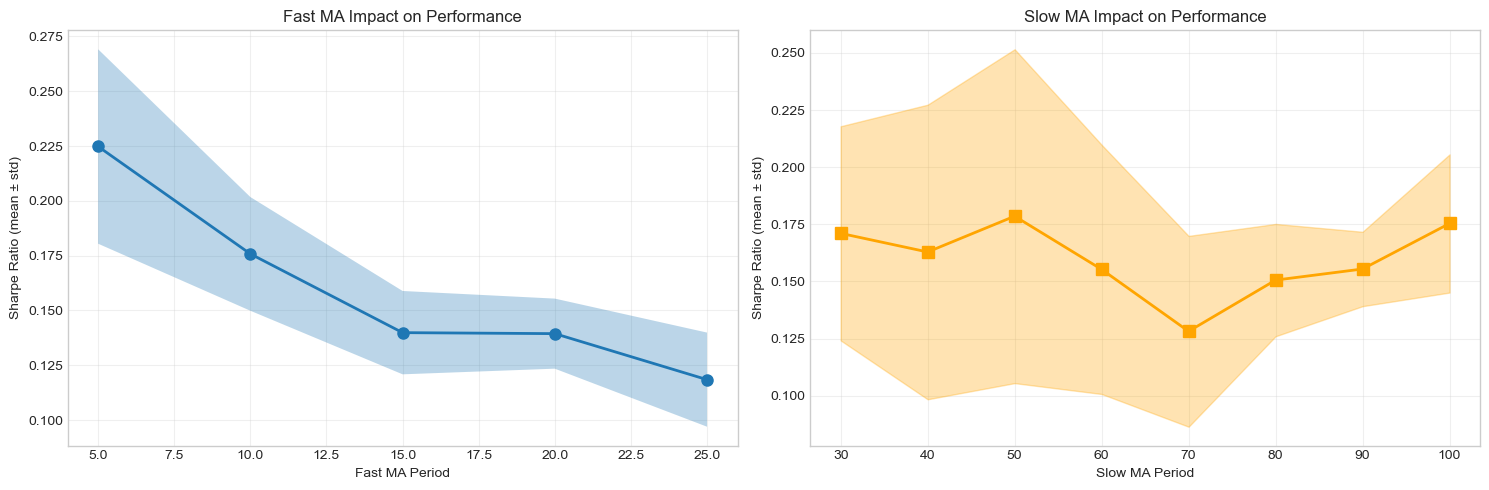

In [18]:
# Plot parameter impact
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Fast MA impact
axes[0].plot(fast_ma_analysis['fast_ma'], fast_ma_analysis['sharpe_ratio_mean'], 
             marker='o', linewidth=2, markersize=8)
axes[0].fill_between(fast_ma_analysis['fast_ma'], 
                      fast_ma_analysis['sharpe_ratio_mean'] - fast_ma_analysis['sharpe_ratio_std'],
                      fast_ma_analysis['sharpe_ratio_mean'] + fast_ma_analysis['sharpe_ratio_std'],
                      alpha=0.3)
axes[0].set_xlabel('Fast MA Period')
axes[0].set_ylabel('Sharpe Ratio (mean ± std)')
axes[0].set_title('Fast MA Impact on Performance')
axes[0].grid(True, alpha=0.3)

# Slow MA impact
axes[1].plot(slow_ma_analysis['slow_ma'], slow_ma_analysis['sharpe_ratio_mean'], 
             marker='s', linewidth=2, markersize=8, color='orange')
axes[1].fill_between(slow_ma_analysis['slow_ma'], 
                      slow_ma_analysis['sharpe_ratio_mean'] - slow_ma_analysis['sharpe_ratio_std'],
                      slow_ma_analysis['sharpe_ratio_mean'] + slow_ma_analysis['sharpe_ratio_std'],
                      alpha=0.3, color='orange')
axes[1].set_xlabel('Slow MA Period')
axes[1].set_ylabel('Sharpe Ratio (mean ± std)')
axes[1].set_title('Slow MA Impact on Performance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

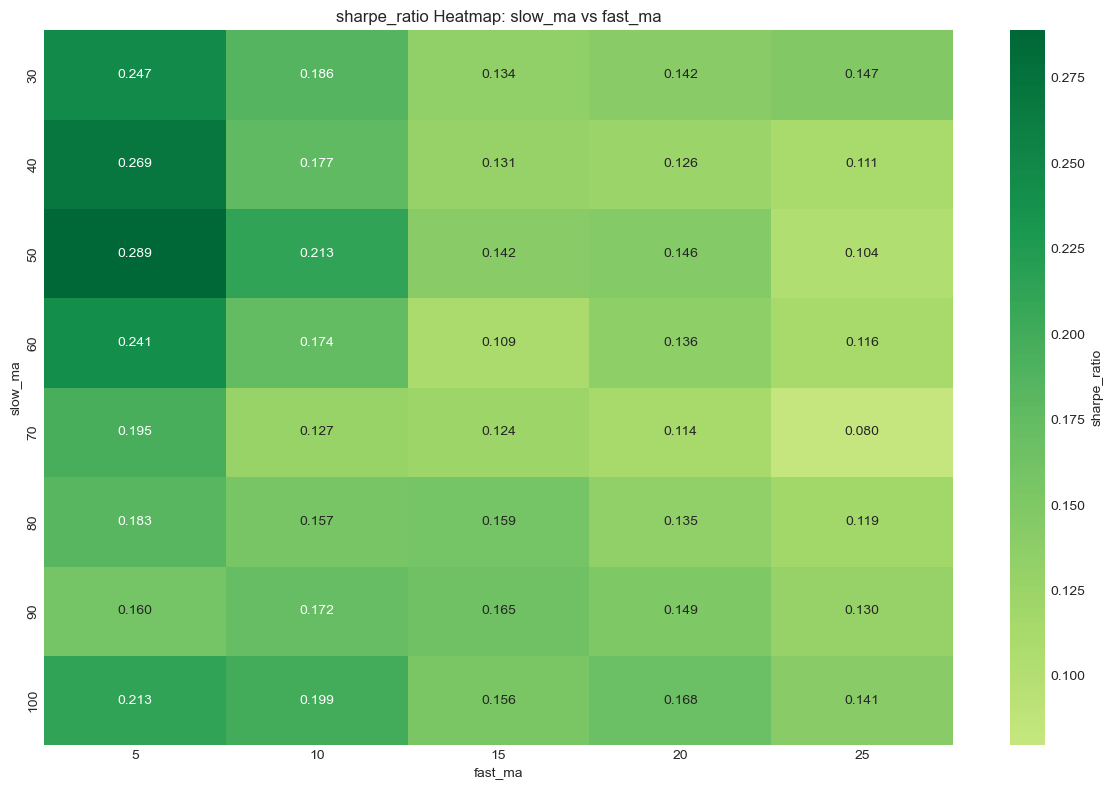

In [19]:
# Create heatmap of fast_ma vs slow_ma
optimizer.plot_parameter_heatmap(
    optimization_result,
    'fast_ma',
    'slow_ma',
    metric='sharpe_ratio',
    figsize=(12, 8)
)
plt.show()

## 7. Test Best Parameters

Run a full backtest with the optimal parameters and generate a detailed report.

In [21]:
# Use the best result from optimization
best_result = optimization_result.best_result

print("🎯 Testing best parameters with PerformanceReport...\n")

# Create performance report with benchmark
report_config = ReportConfig(
    verbose_metrics=True,
    benchmark_symbol='SPY',
    auto_fetch_benchmark=True
)

report = PerformanceReport(
    best_result,
    config=report_config,
    initial_capital=initial_capital
)

# Print report
report.print_report()

🎯 Testing best parameters with PerformanceReport...

📊 PERFORMANCE ANALYSIS

📈 RETURN METRICS:
-------------------------
Total Return:               59.29%
Annualized Return:           1.36%
CAGR:                        1.25%
Best Day:                    6.89%
Worst Day:                  -5.16%
Avg Daily Return:            0.00%

⚠️  RISK METRICS:
--------------------
Volatility:                  4.69%
Sharpe Ratio:                0.289
Sortino Ratio:               0.376
Maximum Drawdown:          -13.44%
Calmar Ratio:                0.093
VaR (95%):                   0.00%
CVaR (95%):                  0.00%
Downside Deviation:          0.00%

📊 TRADING ACTIVITY:
------------------------
Total Trades:                11278
Win Rate:                    72.8%
Profit Factor:                3.35
Average Trade:               0.00%
Winning Trades:                  0
Losing Trades:                   0
Avg Win:                     0.00%
Avg Loss:                    0.00%
Largest Win:           

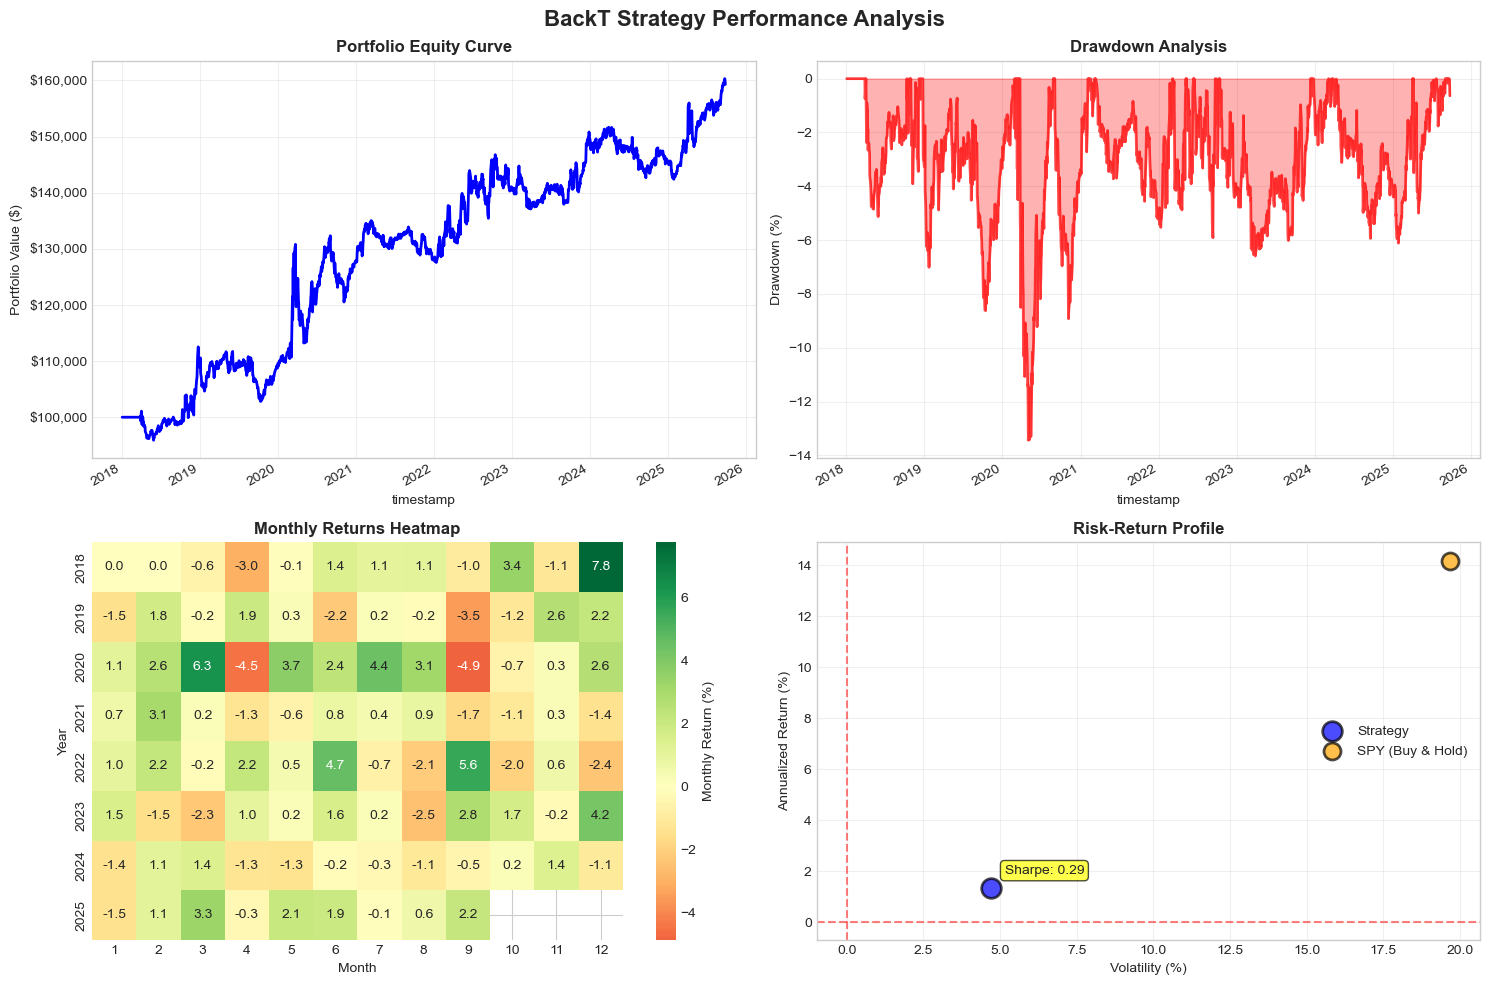

In [22]:
# Generate charts
report.show_charts()

In [23]:
# Get metrics comparison DataFrame
metrics_df = report.get_metrics_dataframe(transpose=True)
print("📊 Optimized Strategy vs Benchmark:\n")
metrics_df.head(15)

📊 Optimized Strategy vs Benchmark:



,Strategy,SPY (Buy & Hold)
total_return,0.592917,1.778792
cagr,0.012531,0.141816
annualized_volatility,0.046950,0.196648
volatility,0.046950,0.196648
annualized_return,0.013561,0.141816
sharpe_ratio,0.288835,0.721166
sortino_ratio,0.375607,0.880296
annual_return,0.013561,0.141816
best_day,0.068943,0.105019
worst_day,-0.051554,-0.109424


## Summary

🎯 **What We Accomplished:**

1. ✅ **Defined optimization parameters** - Set up ranges for fast_ma, slow_ma, and position sizing
2. ✅ **Ran grid search** - Tested all parameter combinations efficiently
3. ✅ **Found optimal parameters** - Identified best settings for maximum Sharpe ratio
4. ✅ **Analyzed parameter sensitivity** - Visualized how each parameter affects performance
5. ✅ **Generated performance report** - Compared optimized strategy vs benchmark

🚀 **Key Features:**

- **Efficient data caching** - Market data fetched only once for all optimization runs
- **Comprehensive results** - All parameter combinations ranked by chosen metric
- **Visual analysis** - Heatmaps and plots showing parameter impact
- **Flexible optimization** - Choose any metric to optimize (Sharpe, returns, max drawdown, etc.)
- **Integration with reporting** - Seamless connection to PerformanceReport for detailed analysis

💡 **Next Steps:**

- Try different optimization metrics (e.g., 'calmar_ratio', 'total_return')
- Expand parameter ranges or add new parameters to optimize
- Test on different time periods or asset universes
- Implement walk-forward optimization to avoid overfitting